## News Mood

In [1]:
#Import dependencies
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests

# Twitter API Keys
from config import (consumer_key,consumer_secret,access_token,access_token_secret)
import json

In [2]:
#Instantiate vader sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# Twitter requires all requests to use OAuth for authentication.
# creating an OAuthHandler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

-----
### Constructing the Scatter plot
-----

In [4]:
target_users = ['@BBC','@CBS','@CNN','@FoxNews','@nytimes']

In [5]:
# variable for holiding the results
sentiment = []

In [6]:
# loop through each news provider
for user in target_users:
    
    # instantiate a counter object
    counter = 0
    
    # loop through 10 pages of tweets to grab 100 tweets for each news provider
    for x in range(5):
    
        # Get all tweets from home feed
        public_tweets = api.user_timeline(id=user,page = x)
    
        # loop through all the tweets
        for tweet in public_tweets:
            
            # run varder analysis on each tweet text
            results = analyzer.polarity_scores(tweet['text'])
            compound = results['compound']
            negative = results['neg']
            neutral = results['neu']
            positive = results['pos']
            
            # add results to an array
            sentiment.append({"text":tweet['text'],
                              "sentiment_compound":compound,
                              "sentiment_negative":negative,
                              "sentiment_neutral" :neutral,
                              "sentiment_positive":positive,
                              "created_at":tweet['created_at'],
                              "tweets_ago":counter,
                              "name":tweet["user"]['name'],
                              "screen_name":tweet["user"]['screen_name']})
            # add to counter
            counter += 1

In [7]:
# convert the sentiment array to a dataframe
sentiments_pd = pd.DataFrame.from_dict(sentiment)

In [8]:
# inspect the head of the dataframe
sentiments_pd.head()

,created_at,name,screen_name,sentiment_compound,sentiment_negative,sentiment_neutral,sentiment_positive,text,tweets_ago
0,Sun Nov 26 21:12:48 +0000 2017,BBC,BBC,0.7028,0.0,0.509,0.491,RT @BBCTwo: Flipping AMAZING. 😲 #RobotWars htt...,0
1,Sun Nov 26 21:11:53 +0000 2017,BBC,BBC,0.3724,0.0,0.797,0.203,"RT @bbcstrictly: We're not crying, you are 😢 @...",1
2,Sun Nov 26 21:11:45 +0000 2017,BBC,BBC,0.8442,0.0,0.712,0.288,"RT @bbcstrictly: ""This has been the best exper...",2
3,Sun Nov 26 21:11:33 +0000 2017,BBC,BBC,0.8070,0.0,0.658,0.342,RT @CBeebiesHQ: Congratulations to @HEYDUGGEE!...,3
4,Sun Nov 26 20:51:01 +0000 2017,BBC,BBC,0.5994,0.0,0.606,0.394,RT @BBCOne: One word: magnificent. #BluePlanet...,4


In [9]:
# arrive at the timestamp of the latest tweet
created_at_dt = []

for item in sentiments_pd['created_at']:
    x = datetime.strptime(item,"%a %b %d %H:%M:%S %z %Y")
    created_at_dt.append(x)
    
date = datetime.strftime(max(created_at_dt),"%d/%-m/%y")

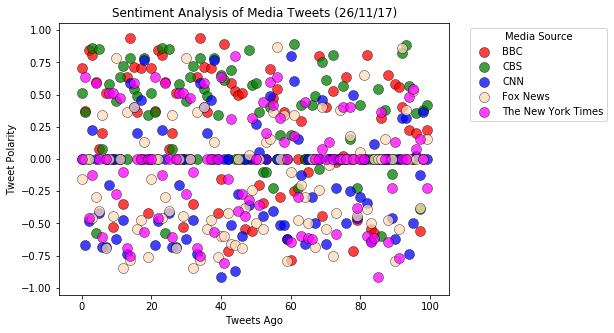

In [10]:
# create the scatter plot
color_names = ["r", "g", "b", "peachpuff", "fuchsia"]
plt.figure(figsize=(7,5))

#counter object
counter = 0

group = sentiments_pd.groupby('name')

# loop through each target user
for item in group.groups.keys():

    df = sentiments_pd[sentiments_pd['name'] == item]
    plt.scatter(        
            x=df['tweets_ago'],
            y=df['sentiment_compound'],
            c = color_names[counter],
            s = 100,
            label = item,
            alpha=0.75,
            edgecolor='black',
            linewidth='0.5')
    counter += 1
    
# incorporate other graph properties
plt.legend(title="Media Source",bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
plt.title(f"Sentiment Analysis of Media Tweets ({date})")
plt.savefig("Output Analysis_News Mood/scatter.png", bbox_inches='tight')
plt.show();

-----
### Constructing the Bar plot
-----

In [11]:
# get the overall sentiment per media and store it in a dataframe
sentiment_overall = sentiments_pd.groupby('name').agg({'sentiment_compound': np.mean}).reset_index()
sentiment_overall

,name,sentiment_compound
0,BBC,0.162220
1,CBS,0.277552
2,CNN,-0.136090
3,Fox News,-0.155632
4,The New York Times,-0.035055


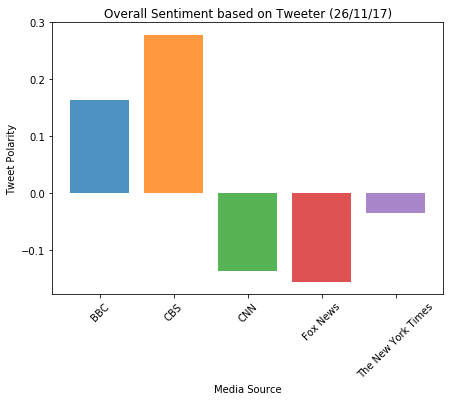

In [12]:
# create the bar plot
plt.figure(figsize=(7,5))
counter = 0

# loop through each target user
for xtick in range(len(sentiment_overall)):
    plt.bar(xtick,
            height=sentiment_overall['sentiment_compound'][counter],
            label =sentiment_overall['name'][counter],
            alpha=0.8)
    counter += 1

# incorporate other graph properties
x_pos = [item for item in range(len(sentiment_overall))]
bar_labels = sentiment_overall['name']
plt.xticks(x_pos,bar_labels,rotation='45')
plt.ylabel("Tweet Polarity")
plt.xlabel("Media Source")
plt.title(f"Overall Sentiment based on Tweeter ({date})")
plt.savefig("Output Analysis_News Mood/bar.png", bbox_inches='tight')
plt.show();

### Observations

    On average, CBS tweets had more positve sentiment compared to other media.
    On average, The Fox News tweets had more negative sentiment.
    On average, The New York Times tweets had more neutral sentiment.